teste


[*********************100%***********************]  1 of 1 completed


Price      Adj Close    Close     High      Low     Open    Volume
Ticker      CMIN3.SA CMIN3.SA CMIN3.SA CMIN3.SA CMIN3.SA  CMIN3.SA
Date                                                              
2021-02-22  5.518456     9.29     9.30     8.67     8.92  10507000
2021-02-23  5.417473     9.12     9.60     9.10     9.50   9243700
2021-02-24  5.435293     9.15     9.28     9.07     9.16   6550600
2021-02-25  5.375891     9.05     9.29     9.00     9.18   6054200
2021-02-26  5.304609     8.93     9.17     8.90     9.15   4849000


c:\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 0.0643
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0071
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0050
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0042
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0052
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0043
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0042
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0039
Epoch 9/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0036
Epoch 10/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0031
Epoch 11/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0030
Epoch 12/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0038
Epoch 13/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0027
Epoch 14/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0029
Epoch 15/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0027
Epoc

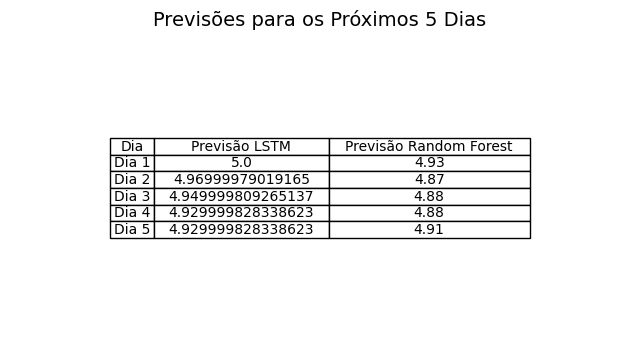

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Baixar dados históricos da ação MGLU3 dos últimos 5 anos
mglu3 = yf.download('CMIN3.SA', period="5y")

# Exibir os primeiros 5 registros
print(mglu3.head())

# Selecionar o preço ajustado
mglu3_close = mglu3['Adj Close'].dropna()

# Criar um DataFrame com os valores ajustados
data = pd.DataFrame(mglu3_close)
data.columns = ['Close']

# Normalizar os dados para os modelos
scaler = MinMaxScaler(feature_range=(0, 1))
data['Scaled_Close'] = scaler.fit_transform(data[['Close']])

# Função para criar janelas de dados
def create_dataset(data, window_size=60):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Criar conjunto de dados
window_size = 60
scaled_data = data['Scaled_Close'].values
X, y = create_dataset(scaled_data, window_size)

# Dividir os dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Ajustar o formato para o LSTM
X_train_lstm = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Criar o modelo LSTM
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=50, return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(units=1))

# Compilar o modelo
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Treinar o modelo
lstm_model.fit(X_train_lstm, y_train, epochs=20, batch_size=32, verbose=1)

# Fazer previsões
lstm_predictions = lstm_model.predict(X_test_lstm)

# Inverter a normalização
lstm_predictions = scaler.inverse_transform(lstm_predictions.reshape(-1, 1))

# Criar o modelo Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Fazer previsões
rf_predictions = rf_model.predict(X_test)

# Inverter a normalização
rf_predictions = scaler.inverse_transform(rf_predictions.reshape(-1, 1))

# Valores reais
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calcular o erro médio quadrático (MSE)
lstm_mse = mean_squared_error(y_test_original, lstm_predictions)
rf_mse = mean_squared_error(y_test_original, rf_predictions)

print(f"LSTM MSE: {lstm_mse}")
print(f"Random Forest MSE: {rf_mse}")

# Obter as previsões para os próximos 5 dias
last_window = scaled_data[-window_size:]
last_window = last_window.reshape(1, window_size, 1)

# Previsão do LSTM
lstm_forecasts = []
for _ in range(5):
    next_prediction = lstm_model.predict(last_window)
    lstm_forecasts.append(scaler.inverse_transform(next_prediction.reshape(-1, 1))[0][0])
    last_window = np.append(last_window[:, 1:, :], next_prediction.reshape(1, 1, 1), axis=1)

# Previsão do Random Forest
last_window_rf = scaled_data[-window_size:]
rf_forecasts = []
for _ in range(5):
    next_rf_prediction = rf_model.predict(last_window_rf.reshape(1, -1))
    rf_forecasts.append(scaler.inverse_transform(next_rf_prediction.reshape(-1, 1))[0][0])
    last_window_rf = np.append(last_window_rf[1:], next_rf_prediction, axis=0)

# Arredondar as previsões
lstm_forecasts = [round(pred, 2) for pred in lstm_forecasts]
rf_forecasts = [round(pred, 2) for pred in rf_forecasts]

# Criar a tabela com pandas
days = [f"Dia {i + 1}" for i in range(5)]
forecast_data = {
    "Dia": days,
    "Previsão LSTM": lstm_forecasts,
    "Previsão Random Forest": rf_forecasts,
}

forecast_table = pd.DataFrame(forecast_data)

# Criar o plot da tabela
plt.figure(figsize=(8, 4))
plt.axis('tight')
plt.axis('off')

# Adicionar a tabela ao plot
table_plot = plt.table(
    cellText=forecast_table.values,
    colLabels=forecast_table.columns,
    loc='center',
    cellLoc='center',
    colLoc='center'
)

# Estilizar a tabela
table_plot.auto_set_font_size(False)
table_plot.set_fontsize(10)
table_plot.auto_set_column_width(col=list(range(len(forecast_table.columns))))

# Exibir o plot
plt.title("Previsões para os Próximos 5 Dias", fontsize=14)
plt.show()
